# Transformer 实现

Eileen Zhang 2020/8/31

注:以下是在google colab 上GPU跑的

![transformer](https://pic2.zhimg.com/80/v2-4b53b731a961ee467928619d14a5fd44_720w.jpg)

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
import io
import re

In [3]:
import jieba

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
file = "/content/drive/My Drive/cmn.txt"

## 数据处理

### 数据查看 预处理

In [7]:
def preprocess_sentence(w):
    w = w.lower().strip()

    # 在单词与跟在其后的标点符号之间插入一个空格
    # https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    w = w.rstrip().strip()

    return w

In [8]:
def read_txt(path):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines]

    return zip(*word_pairs)

In [9]:
en_data, cn_data, _ = read_txt(file)

In [ ]:
cn_data[-5:]

('我母亲的法语比我父亲的英语要好，所以他们通常用法语交流。',
 '汤姆不知如何翻译“计算机”一词，因为同他谈话的人从未见过一台。',
 '即使是现在，我偶尔还是想见到你。不是今天的你，而是我记忆中曾经的你。',
 '你很容易把母语说得通顺流畅，却很容易把非母语说得不自然。',
 '如果一個人在成人前沒有機會習得目標語言，他對該語言的認識達到母語者程度的機會是相當小的。')

In [10]:
cn_data = [" ".join(jieba.cut(x, cut_all=False)) for x in cn_data]

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.834 seconds.
Prefix dict has been built successfully.


In [ ]:
cn_data[-5:]

['我 母亲 的 法语 比 我 父亲 的 英语 要 好 ， 所以 他们 通常 用 法语 交流 。',
 '汤姆 不知 如何 翻译 “ 计算机 ” 一词 ， 因为 同 他 谈话 的 人 从未见过 一台 。',
 '即使 是 现在 ， 我 偶尔 还是 想 见到 你 。 不是 今天 的 你 ， 而是 我 记忆 中 曾经 的 你 。',
 '你 很 容易 把 母语 说 得 通顺 流畅 ， 却 很 容易 把 非 母语 说 得 不 自然 。',
 '如果 一個 人 在 成人 前 沒 有 機會習 得 目標 語言 ， 他 對 該 語言 的 認識 達 到 母語者 程度 的 機會 是 相當 小 的 。']

In [11]:
# 给句子加上开始和结束标记
# 以便模型知道何时开始和结束预测
en_data = ['<start> ' + w + ' <end>' for w in en_data]
cn_data = ['<start> ' + w + ' <end>' for w in cn_data]

In [12]:
en_data[-5:],cn_data[-5:]

(['<start> my mother speaks french better than my father speaks english , so they usually speak to each other in french . <end>',
  "<start> tom didn't know how to translate the word computer because the people he was talking to had never seen one . <end>",
  "<start> even now , i occasionally think i'd like to see you . not the you that you are today , but the you i remember from the past . <end>",
  "<start> it's very easy to sound natural in your own native language , and very easy to sound unnatural in your non-native language . <end>",
  "<start> if a person has not had a chance to acquire his target language by the time he's an adult , he's unlikely to be able to reach native speaker level in that language . <end>"],
 ['<start> 我 母亲 的 法语 比 我 父亲 的 英语 要 好 ， 所以 他们 通常 用 法语 交流 。 <end>',
  '<start> 汤姆 不知 如何 翻译 “ 计算机 ” 一词 ， 因为 同 他 谈话 的 人 从未见过 一台 。 <end>',
  '<start> 即使 是 现在 ， 我 偶尔 还是 想 见到 你 。 不是 今天 的 你 ， 而是 我 记忆 中 曾经 的 你 。 <end>',
  '<start> 你 很 容易 把 母语 说 得 通顺 流畅 ， 却 很 容易 把 非 母语 说 得 不 自

### 创建dataset

In [13]:
def tokenize(txt):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
    tokenizer.fit_on_texts(txt)
    tensor = tokenizer.texts_to_sequences(txt)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,padding='post')
    return tensor, tokenizer

In [14]:
en_tensor, en_tokenizer = tokenize(en_data)
cn_tensor, cn_tokenizer = tokenize(cn_data)

In [15]:
en_tensor_length, cn_tensor_length = en_tensor.shape[1], cn_tensor.shape[1]

In [16]:
en_tensor_length, cn_tensor_length

(36, 32)

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
en_tensor_train, en_tensor_val, cn_tensor_train, cn_tensor_val = train_test_split(en_tensor, cn_tensor, test_size=0.2)

In [19]:
en_tensor_train.shape, en_tensor_val.shape

((18755, 36), (4689, 36))

In [20]:
BUFFER_SIZE = len(en_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = BUFFER_SIZE//BATCH_SIZE

vocab_en_size = len(en_tokenizer.word_index)+1
vocab_cn_size = len(cn_tokenizer.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((en_tensor_train, cn_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [21]:
example_en_batch, example_cn_batch = next(iter(dataset))
example_en_batch.shape, example_cn_batch.shape

(TensorShape([64, 36]), TensorShape([64, 32]))

In [23]:
vocab_en_size = len(en_tokenizer.word_index)+2
vocab_cn_size = len(cn_tokenizer.word_index)+2

# Position embedding 位置编码

Word Embedding+Position Embedding 取代RNN

In [24]:
#pos 词语在句子中的位置,i 在embeding中的位置,embeding_dims embeding length
#pos.shape [sentence_length,1]
#i.shape [1, embeding_dims]
# result.shape [sentence_length, embeding_dims]
def get_angles(pos, i, embeding_dims):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(embeding_dims))
    return pos * angle_rates

In [25]:
def positional_encoding(max_seq_len, embeding_dims):
    
    angle_rads = get_angles(np.arange(max_seq_len)[:, np.newaxis],
                            np.arange(embeding_dims)[np.newaxis, :],
                            embeding_dims)
  
    # 将 sin 应用于数组中的偶数索引（indices）；2i
    #第一个冒号是从0后所有值,第二个冒号是走2步
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    # 将 cos 应用于数组中的奇数索引；2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)


In [26]:
def plot_position_encoding(positional_encoding):
    
    plt.pcolormesh(positional_encoding[0], cmap = 'RdBu')
    plt.xlabel('Depth')
    plt.xlim((0,512))
    plt.ylabel('Position')
    plt.colorbar()
    plt.show()

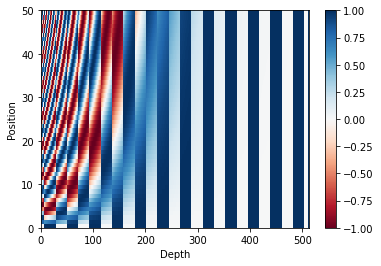

In [27]:
plot_position_encoding(positional_encoding(50,512))

# Mask

- Pading Mask
这确保了模型不会将填充作为输入。该 mask 表明填充值 0 出现的位置：在这些位置 mask 输出 1，否则输出 0。

In [28]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    #print(seq)
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [29]:
create_padding_mask(tf.constant([[2, 2, 2, 2, 2], [0, 2, 2, 2, 2], [0, 0, 2, 2, 2]]))

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 0.]]],


       [[[1., 0., 0., 0., 0.]]],


       [[[1., 1., 0., 0., 0.]]]], dtype=float32)>

- 预测第三个词，将仅使用第一个和第二个词。与此类似，预测第四个词，仅使用第一个，第二个和第三个词，依此类推。

In [30]:
# 
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [31]:
create_look_ahead_mask(4)

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0., 1., 1., 1.],
       [0., 0., 1., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.]], dtype=float32)>

# Multi-head Attention

![Multi-head Attention](data/multi_attention.png)

![%E5%9B%BE%E7%89%87.png](https://img-blog.csdnimg.cn/20190504124806248.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L25pbmd5YW5nZ2VnZQ==,size_16,color_FFFFFF,t_70)

**scaled_dot_product_attention 公式**  

$softmax(Q * K^T / \sqrt{d_k}) * V $  

除以$\sqrt{d_k}$ 防止 Q * K 后值过大,假设Q K 符合正态分布; 则 Q * K 符合 0 ~ $\sqrt{d_k}$ 的正态分布;除以$\sqrt{d_k}$进行归一化

In [32]:
def scaled_dot_product_attention(q, k, v, mask):
    """计算注意力权重。
    
    参数:
      q: 请求的形状 == (..., seq_len_q, embedding_dims)
      k: 主键的形状 == (..., seq_len_k, embedding_dims)
      v: 数值的形状 == (..., seq_len_v, embedding_dims)
      mask: 把需要mask的部分加上-1e9 ,从而使该部分值经过 softmax后趋近于0 
      
    返回值:
      outs.shape = (..., seq_len_q, embedding_dims)
      输出，注意力权重
    """
    
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
    # 缩放 matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    # 将 mask 加入到缩放的张量上。
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  
    
    # softmax 在最后一个轴（seq_len_k）上归一化，因此分数
    # 相加等于1。
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, embedding_dims)

    return output, attention_weights


In [33]:
# V,K,Q 分别做num_heads个liner 不如做一个liner 分成num_heads 份 
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    num_heads: the numbers of heads
    embeding_dims : the q, k, v dims for one head
    
    outs.shape =  (batch_size, seq_len_q, embeding_dims)
    """    
    def __init__(self, num_heads, embeding_dims):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.embeding_dims = embeding_dims
        
        #print('embeding_dims', embeding_dims , 'self.num_heads',self.num_heads)
        #print('embeding_dims % self.num_heads == 0',embeding_dims % self.num_heads)
        assert embeding_dims % self.num_heads == 0

        self.dims = embeding_dims // self.num_heads
    
        self.wq = tf.keras.layers.Dense(self.embeding_dims)
        self.wk = tf.keras.layers.Dense(self.embeding_dims)
        self.wv = tf.keras.layers.Dense(self.embeding_dims)
    
        self.dense = tf.keras.layers.Dense(self.embeding_dims)
        
    def split_heads(self, x, batch_size):
        """分拆最后一个维度到 (num_heads, embeding_dims).
        转置结果使得形状为 (batch_size, num_heads, seq_len, embeding_dims)
        """
        #做归一化 ? 未实现      
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.dims))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
    
        q = self.wq(q)  # (batch_size, seq_len, embeding_dims)
        k = self.wk(k)  # (batch_size, seq_len, embeding_dims)
        v = self.wv(v)  # (batch_size, seq_len, embeding_dims)
    
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, dims)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, dims)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, dims)
        #print('q', q.shape)
        #print('k', k.shape)
        #print('v', v.shape)
    
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, dims)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, dims)

        concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.embeding_dims))  # (batch_size, seq_len_q, embeding_dims)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, embeding_dims)
        #print('scaled_attention', scaled_attention.shape)
        #print('concat_attention', concat_attention.shape)
        #print('output', output.shape)
        return output, attention_weights


# Encoder

inputs.shape = (batch_size, input_seq_len)  
outs.shape = (batch_size, input_seq_len, embeding_dims)

In [34]:
# outs.shape = (batch_size, seq_len, embeding_dims)
def feed_forward_network(units, embeding_dims):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),  # (batch_size, seq_len, units)
        tf.keras.layers.Dense(embeding_dims)  # (batch_size, seq_len, embeding_dims)
    ])


In [35]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, embeding_dims, num_heads, ffn_units, rate=0.1):
        super(EncoderLayer, self).__init__()
        
        self.mha = MultiHeadAttention(num_heads, embeding_dims)
        self.ffn = feed_forward_network(ffn_units, embeding_dims)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, embeding_dims)
        attn_output = self.dropout1(attn_output, training=training)
        #print('attn_output', attn_output.shape)
        #print('x', x.shape)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, embeding_dims)
    
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, embeding_dims)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, embeding_dims)
        return out2
    

In [36]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, num_heads, embeding_dims, ffn_units, input_vocab_size,
                 max_seq_len, rate=0.1):
        super(Encoder, self).__init__()

        self.embeding_dims = embeding_dims
        self.num_layers = num_layers
    
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, embeding_dims)
        self.pos_encoding = positional_encoding(max_seq_len, 
                                            self.embeding_dims)
    
    
        self.enc_layers = [EncoderLayer(embeding_dims, num_heads, ffn_units, rate) for _ in range(num_layers)]
  
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
    
        # 将嵌入和位置编码相加。
        x = self.embedding(x)  # (batch_size, input_seq_len, embeding_dims)
        x *= tf.math.sqrt(tf.cast(self.embeding_dims, tf.float32)) #使x权重 大于pos_encoding权重
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)
    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
    
        return x  # (batch_size, input_seq_len, embeding_dims)

In [37]:
test_encoder = Encoder(num_layers = 4 , num_heads = 8, embeding_dims = 256, ffn_units = 100, input_vocab_size = vocab_en_size,
                 max_seq_len = en_tensor_length, rate=0.1)

test_encoder_outs = test_encoder(tf.random.uniform(example_en_batch.shape), training=False, mask=None)

test_encoder_outs.shape

TensorShape([64, 36, 256])

# Decoder

In [38]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, num_heads, embeding_dims, ffn_units, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(num_heads, embeding_dims)
        self.mha2 = MultiHeadAttention(num_heads, embeding_dims)

        self.ffn = feed_forward_network(ffn_units, embeding_dims)
 
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, embeding_dims)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, embeding_dims)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
    
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, embeding_dims)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, embeding_dims)
    
        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, embeding_dims)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, embeding_dims)
    
        return out3, attn_weights_block1, attn_weights_block2


In [39]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, num_heads, embeding_dims, ffn_units, target_vocab_size, max_seq_len, rate=0.1):
        super(Decoder, self).__init__()

        self.embeding_dims = embeding_dims
        self.num_layers = num_layers
    
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, embeding_dims)
        self.pos_encoding = positional_encoding(max_seq_len, embeding_dims)
    
        self.dec_layers = [DecoderLayer(num_heads = num_heads, embeding_dims = embeding_dims, ffn_units = ffn_units, rate = rate) 
                       for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}   
        x = self.embedding(x)  # (batch_size, target_seq_len, embeding_dims)
        x *= tf.math.sqrt(tf.cast(self.embeding_dims, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
    
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,look_ahead_mask, padding_mask)
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        # x.shape == (batch_size, target_seq_len, embeding_dims)
        return x, attention_weights


In [40]:
test_decoder = Decoder(num_layers=2, embeding_dims=512, num_heads=8, 
                         ffn_units=20, target_vocab_size=800,
                         max_seq_len=200)

output, attn = test_decoder(tf.random.uniform((64, 26)), 
                              enc_output=test_encoder_outs, 
                              training=False, look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape


(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 36]))

# Transformer

In [41]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, embeding_dims, num_heads, ffn_units, input_vocab_size, 
               target_vocab_size, input_max_seq_len, target_max_seq_len, rate=0.1):
        
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers = num_layers, embeding_dims = embeding_dims, num_heads = num_heads, ffn_units = ffn_units, 
                           input_vocab_size = input_vocab_size, max_seq_len = input_max_seq_len, rate = rate)

        self.decoder = Decoder(num_layers = num_layers, embeding_dims = embeding_dims, num_heads = num_heads, ffn_units = ffn_units, 
                           target_vocab_size = target_vocab_size, max_seq_len = target_max_seq_len, rate = rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, embeding_dims)
    
        # dec_output.shape == (batch_size, tar_seq_len, embeding_dims)
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
        return final_output, attention_weights


In [42]:
test_transformer = Transformer(
    num_layers=2, embeding_dims=512, num_heads=8, ffn_units=5, 
    input_vocab_size=200, target_vocab_size=300, 
    input_max_seq_len=65, target_max_seq_len=30)

temp_input = tf.random.uniform((64, 62))
temp_target = tf.random.uniform((64, 26))

fn_out, _ = test_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)


TensorShape([64, 26, 300])

# Loss Function

In [43]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Mean

optimizer = tf.keras.optimizers.Adam()

In [44]:
def create_masks(inp, tar):
    # 编码器填充遮挡
    enc_padding_mask = create_padding_mask(inp)
  
    # 在解码器的第二个注意力模块使用。
    # 该填充遮挡用于遮挡编码器的输出。
    dec_padding_mask = create_padding_mask(inp)
  
    # 在解码器的第一个注意力模块使用。
    # 用于填充（pad）和遮挡（mask）解码器获取到的输入的后续标记（future tokens）。
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

In [45]:
num_layers = 4
embeding_dims = 128
ffn_units = 512
num_heads = 8

    
transformer = Transformer(num_layers = num_layers, embeding_dims = embeding_dims, num_heads = num_heads, ffn_units = ffn_units,
                          input_vocab_size = vocab_en_size, target_vocab_size = vocab_cn_size, 
                          input_max_seq_len = vocab_en_size, 
                          target_max_seq_len = vocab_cn_size)

In [46]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = SparseCategoricalCrossentropy(from_logits=True, reduction='none')(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
  
    return tf.reduce_mean(loss_)

In [50]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
  
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
    return loss

# 训练

In [48]:
import time

In [53]:
%%time
EPOCHS = 100

for epoch in range(EPOCHS):
    total_loss = 0
    for (batch_id, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ)
        total_loss += batch_loss
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,total_loss / steps_per_epoch))


Epoch 1 Loss 1.2583
Epoch 2 Loss 1.2531
Epoch 3 Loss 1.2450
Epoch 4 Loss 1.2392
Epoch 5 Loss 1.2349
Epoch 6 Loss 1.2297
Epoch 7 Loss 1.2288
Epoch 8 Loss 1.2229
Epoch 9 Loss 1.2153
Epoch 10 Loss 1.2065
Epoch 11 Loss 1.2025
Epoch 12 Loss 1.2021
Epoch 13 Loss 1.1955
Epoch 14 Loss 1.1970
Epoch 15 Loss 1.1853
Epoch 16 Loss 1.1797
Epoch 17 Loss 1.1773
Epoch 18 Loss 1.1769
Epoch 19 Loss 1.1674
Epoch 20 Loss 1.1652
Epoch 21 Loss 1.1615
Epoch 22 Loss 1.1578
Epoch 23 Loss 1.1536
Epoch 24 Loss 1.1502
Epoch 25 Loss 1.1464
Epoch 26 Loss 1.1437
Epoch 27 Loss 1.1417
Epoch 28 Loss 1.1403
Epoch 29 Loss 1.1329
Epoch 30 Loss 1.1292
Epoch 31 Loss 1.1297
Epoch 32 Loss 1.1296
Epoch 33 Loss 1.1212
Epoch 34 Loss 1.1158
Epoch 35 Loss 1.1156
Epoch 36 Loss 1.1114
Epoch 37 Loss 1.1147
Epoch 38 Loss 1.1068
Epoch 39 Loss 1.1048
Epoch 40 Loss 1.1154
Epoch 41 Loss 1.1011
Epoch 42 Loss 1.0959
Epoch 43 Loss 1.0937
Epoch 44 Loss 1.0946
Epoch 45 Loss 1.0922
Epoch 46 Loss 1.0900
Epoch 47 Loss 1.0842
Epoch 48 Loss 1.0802
E